# Status de Requições de Materiais

## Dataset

Unimos datasets das Requisições de Materiais no grupo de Materiais, dos Dados Abertos da UFRN, desde 1998

In [112]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objs as go

import pandas as pd

# Lê um arquivo CSV como delimitador ;
rm = pd.read_csv('data/all_data.csv', delimiter=',')

# Exibe as primeiras linhas do DataFrame 'rm' para visualizar os dados
rm.head()

,numero,ano,requisicao,data,id_unidade_requisitante,unidade_requisitante,id_unidade_custo,unidade_custo,observacoes,grupo_material,convenio,status,tipo_requisicao,almoxarifado,valor
0,2469,1998,2469/1998,29/12/1998,283,EDITORA UNIVERSITÁRIA,283,EDITORA UNIVERSITÁRIA,NaN,GENEROS DE ALIMENTACAO,False,FINALIZADA,REQUISIÇÃO DE MATERIAL,ALMOXARIFADO CENTRAL,"R$ 13,80"
1,2468,1998,2468/1998,29/12/1998,1463,RESIDENCIAS UNIVERSITÁRIAS,1463,RESIDENCIAS UNIVERSITÁRIAS,NaN,GAS ENGARRAFADO,False,FINALIZADA,REQUISIÇÃO DE MATERIAL,ALMOXARIFADO CENTRAL,"R$ 84,00"
2,2470,1998,2470/1998,29/12/1998,253,NÚCLEO PERMANENTE DE CONCURSOS,253,NÚCLEO PERMANENTE DE CONCURSOS,NaN,GENEROS DE ALIMENTACAO,False,FINALIZADA,REQUISIÇÃO DE MATERIAL,ALMOXARIFADO CENTRAL,"R$ 4,60"
3,2471,1998,2471/1998,29/12/1998,285,HOSPITAL UNIVERSITARIO ANA BEZERRA,285,HOSPITAL UNIVERSITARIO ANA BEZERRA,NaN,GENEROS DE ALIMENTACAO,False,FINALIZADA,REQUISIÇÃO DE MATERIAL,ALMOXARIFADO CENTRAL,"R$ 34,50"
4,2460,1998,2460/1998,28/12/1998,1423,DIRETORIA DE LOGÍSTICA - PROAD,1423,DIRETORIA DE LOGÍSTICA - PROAD,NaN,MATERIAL DE LIMPEZA E PRODUTOS DE HIGIENIZACAO,False,FINALIZADA,REQUISIÇÃO DE MATERIAL,ALMOXARIFADO CENTRAL,"R$ 86,56"


## Contexto

Quando uma unidade precisa de algum material, ela abre uma requisição para o almoxarifado. Nessa requisição, deve ter o preço estimado desse material e a unidade que vai custear esse material. Assim, o almoxarifado pode aprová-la e dar início a ordem de compra.

## Ideia

Neste dataset, queremos que, dada uma requisição, prever ele vai ser negada ou autorizada pelo almoxarifado. Além disso, investigar qual perfil das requisições que têm mais chances de serem aprovadas.

## Preprocessamento

Como esse dataset possui registros de devolução e requisições que envolvem serviços, vamos considerar apenas as requisições de material da instituição

In [113]:
df = rm[rm['tipo_requisicao'] == 'REQUISIÇÃO DE MATERIAL']

Algumas colunas em nada agregam ao nosso objetivo, portanto vamos retirá-las

In [114]:
df = df.drop(['numero','ano','requisicao','data','observacoes','tipo_requisicao','id_unidade_custo','id_unidade_requisitante'], axis=1)

A coluna status é multivalorada, mas apenas nos importa saber se a requisição foi negada ou não.

In [115]:
# Filtrar apenas requisições negadas, autorizadas e que tiveram a compra efetuada
df = df[df['status'].isin(['NEGADA', 'AUTORIZADA', 'COMPRA', 'LIQUIDADA', 'EM_LIQUIDACAO'])]
df['status'] = df['status'].apply(lambda x: 1 if x == 'NEGADA' else 0)

In [116]:
# A partir de qual classe cortar
cutoff = 20

"""
Função para agrupar uma categórica

Parâmetros:
    df : conjunto de dados
    column : nome da coluna
"""
def group_categorical_column(df, column):
    dataframe = df[column].value_counts().reset_index()
    display(dataframe.head(cutoff))

In [117]:
cost_units = df['unidade_custo'].value_counts()[:cutoff]
group_categorical_column(df, 'unidade_custo')

,unidade_custo,count
0,GESTÃO DE CONTRATOS,182
1,PROGRAMA DE PÓS-GRADUAÇÃO EM PATOLOGIA ORAL,140
2,RESERVA TÉCNICA,130
3,PROGRAMA DE PÓS-GRADUAÇÃO EM ENGENHARIA QUÍMICA,117
4,CENTRO DE CIÊNCIAS DA SAÚDE,114
5,NUCLEO DE PESQUISA EM ALIMENTOS E MEDICAMENTOS,103
6,PROGRAMA DE PÓS-GRADUAÇÃO EM BIOQUÍMICA,93
7,PROGRAMA REUNI,87
8,GASTOS COMUNS,82
9,ESCOLA AGRÍCOLA DE JUNDIAÍ,79


In [118]:
request_units = df['unidade_requisitante'].value_counts()[:cutoff]
group_categorical_column(df, 'unidade_requisitante')

,unidade_requisitante,count
0,GESTÃO DE CONTRATOS,169
1,PROGRAMA DE PÓS-GRADUAÇÃO EM PATOLOGIA ORAL,145
2,DIRETORIA DE MANUTENÇÃO DE INSTALAÇÕES FÍSICAS,135
3,PROGRAMA DE PÓS-GRADUAÇÃO EM ENGENHARIA QUÍMICA,109
4,NUCLEO DE PESQUISA EM ALIMENTOS E MEDICAMENTOS,107
5,DMP - SECRETARIA ADMINISTRATIVA,100
6,PROGRAMA DE PÓS-GRADUAÇÃO EM BIOQUÍMICA,94
7,ESCOLA AGRÍCOLA DE JUNDIAÍ,85
8,RESERVA TÉCNICA,67
9,SUPERINTENDÊNCIA DE TECNOLOGIA DA INFORMAÇÃO,62


In [119]:
almoxarifado = df['almoxarifado'].value_counts()
group_categorical_column(df, 'almoxarifado')

,almoxarifado,count
0,ALMOXARIFADO CENTRAL,445
1,ALMOXARIFADO DE MATERIAIS DE MANUTENÇÃO DE IMÓ...,159
2,ALMOXARIFADO - CCS,66
3,ALMOXARIFADO - CT,37
4,ALMOXARIFADO - CB,23
5,ALMOXARIFADO - CCSA,20
6,ALMOXARIFADO - CCHLA - PORTARIA 097/2014,20
7,ALMOXARIFADO - CCET,12
8,ALMOXARIFADO - CCHLA,12
9,HUOL - ALMOXARIFADO GERAL,2


In [120]:
material_group = df['grupo_material'].value_counts()[:cutoff]
group_categorical_column(df, 'grupo_material')

,grupo_material,count
0,MATERIAL QUIMICO,443
1,MATERIAL DE EXPEDIENTE,274
2,MATERIAL LABORATORIAL,221
3,GENEROS DE ALIMENTACAO,209
4,MOBILIARIO EM GERAL,201
5,"APARELHOS, EQUIP. E UTENS. MED., ODONT., LABOR...",157
6,MATERIAL DE PROCESSAMENTO DE DADOS,147
7,MATERIAL PARA MANUTENCAO DE BENS IMOVEIS,123
8,VEICULOS DE TRACAO MECANICA,115
9,MATERIAL ELETRICO E ELETRÔNICO,110


Categorização das colunas com base nos agrupamentos feitos anteriormente

In [121]:
def categorize_almoxarifado(value):
    if pd.isna(value):
        return len(almoxarifado.index) + 1
    for idx, category in enumerate(almoxarifado.index):
        if value.startswith(category):
            return idx
    return len(almoxarifado.index)

def categorize_cost_unit(value):
    for idx, category in enumerate(cost_units.index):
        if value.startswith(category):
            return idx
    return len(cost_units.index)

def categorize_request_unit(value):
    for idx, category in enumerate(request_units.index):
        if value.startswith(category):
            return idx
    return len(request_units.index)

def categorize_material_group(value):
    if pd.isna(value):
        return len(material_group.index) + 1
    for idx, category in enumerate(material_group.index):
        if value.startswith(category):
            return idx
    return len(material_group.index)

def categorize_convenio(value):
    return 1 if value else 0

df['almoxarifado'] = df['almoxarifado'].apply(categorize_almoxarifado)
df['unidade_custo'] = df['unidade_custo'].apply(categorize_cost_unit)
df['unidade_requisitante'] = df['unidade_requisitante'].apply(categorize_request_unit)
df['grupo_material'] = df['grupo_material'].apply(categorize_material_group)
df['convenio'] = df['convenio'].apply(categorize_convenio)

A coluna dos valores das requisições precisa ser transformada em valores decimais e depois categorizada

In [122]:
import re

rgx_remove_prefix = r'R\$|\s'
rgx_only_last_point = r'\.(?=[^.]*\.)'

df.loc[:,'valor'] = df['valor'].apply(lambda value: re.sub(rgx_only_last_point, '', re.sub(rgx_remove_prefix, '', value).replace(',', '.')))
df.loc[:,'valor'] = df['valor'].astype(float)

Verificar linhas que possuem valores NaN

In [123]:
df.isna().sum()

unidade_requisitante    0
unidade_custo           0
grupo_material          0
convenio                0
status                  0
almoxarifado            0
valor                   0
dtype: int64

Abaixo é possível ver quantas requisições foram negadas (status 0) e quantas foram aprovadas (status 1)

In [124]:
df['status'].value_counts()

status
0    3374
1     801
Name: count, dtype: int64

In [125]:
df

,unidade_requisitante,unidade_custo,grupo_material,convenio,status,almoxarifado,valor
39292,16,20,19,0,0,14,49330.04
39841,20,20,5,0,0,14,189355.0
39842,20,20,17,0,0,14,1000.0
40717,20,20,20,0,0,14,1194.06
40802,20,20,20,0,0,14,1232.22
...,...,...,...,...,...,...,...
620056,20,20,20,0,1,0,1053.44
621466,2,20,21,0,1,1,3695.13
621869,20,20,3,0,1,0,600.0
622018,20,20,20,0,1,0,20.0


In [126]:
duplicated_rows = df.duplicated()
count_duplicates = duplicated_rows.sum()
print(f'Número de linhas duplicadas: {count_duplicates}')

Número de linhas duplicadas: 245


## Avaliação de classificador

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Classe para avaliar as técnicas supervisionadas
class AssessClassifier:
    """
    Inicialização da avaliação do classificador

    Parâmetros:
        df    (DataFrame)      : dataframe onde se encontram os dados
        clf   (sklearn object) : classificador
        label (string)         : nome da coluna do rótulo no dataframe
    """
    def __init__(self, df, clf, label):
        # Armazena o dataframe e o classificador nas propriedades
        self.df = df
        self.clf = clf
        
        # Separando X (features) e y (label)
        X = df.drop(label, axis=1)
        y = df.status

        # Divisao treino e test
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.20, random_state=0)

    """
    Treinamento do classificador
    """
    def train(self):
        # Treinar classificador
        self.clf = self.clf.fit(self.X_train, self.y_train)
        # Verificar score com dados de treino
        print('Score do treinamento: ', self.clf.score(self.X_train, self.y_train))

    """
    Teste do classificador
    """
    def test(self):
        # Faça a predição
        self.y_pred = self.clf.predict(self.X_test)

    """
    Plotar matriz de confusão
    """
    def get_cm(self):
        return confusion_matrix(self.y_test,self.y_pred)

    """
    Plotar curva ROC
    """
    def get_roc(self):
        y_prob = self.clf.predict_proba(self.X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(self.y_test, y_prob)
        return fpr, tpr

    """
    Mostrar acurácia, precisão e sensibilidade do modelo
    """
    def get_metrics(self):
        accuracy = accuracy_score(self.y_test, self.y_pred)
        precision = precision_score(self.y_test, self.y_pred)
        recall = recall_score(self.y_test, self.y_pred)
        return accuracy, precision, recall

    """
    Refinar hiperparâmetros pela otimização pseudo aleatória
    """
    def refine_rs(self, search_space):
        rs = RandomizedSearchCV(
            self.clf, 
            search_space, 
            n_iter=10, 
            scoring='accuracy', 
            verbose=True, cv=5,
            n_jobs=-1, 
            return_train_score=True)
        rs.fit(self.X_train, self.y_train)
        
        return rs.best_estimator_

    """
    Refinar hiperparâmetros pela otimização por grid search
    """
    def refine_gs(self, search_space):
        gs = GridSearchCV(
          self.clf,
          search_space,
          cv=5,
          scoring='accuracy',
          return_train_score=True)
        gs.fit(self.X_train, self.y_train)
        
        return gs.best_estimator_
        
    """
    Refinar hiperparametros pela busca bayesiana
    """
    def refine_bs(self, search_space):
        bs = BayesSearchCV(
            self.clf,
            search_space, 
            n_iter = 10, 
            scoring = 'accuracy', 
            n_jobs = 1, cv = 5)
        bs.fit(self.X_train, self.y_train)
        
        return bs.best_estimator_

## Técnicas supervisionadas

### Gradient Boosting Tree

In [128]:
from sklearn.ensemble import HistGradientBoostingClassifier

gb_clf = HistGradientBoostingClassifier()

gb = AssessClassifier(df, gb_clf, 'status')
gb.train()
gb.test()

gb.get_metrics()

Score do treinamento:  0.9844311377245509


(0.9508982035928144, 0.8496732026143791, 0.8783783783783784)

### Floresta Aleatória

In [129]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier() 

rf = AssessClassifier(df, rf_clf, 'status')
rf.train()
rf.test()

rf.get_metrics()

Score do treinamento:  0.9970059880239521


(0.9556886227544911, 0.8675496688741722, 0.8851351351351351)

### Refino dos hiperparâmetros

In [130]:
rf_search_space = {
    'bootstrap': [True],              # Se amostras são retiradas com reposição
    'max_depth': [10, 25, 30],        # Profundidade máxima da árvore
    'max_features': [2, 3],           # Número máximo de features consideradas para divisão
    'min_samples_leaf': [3, 5],       # Número mínimo de amostras necessárias para estar em um nó folha
    'min_samples_split': [8, 10, 12], # Número mínimo de amostras necessárias para dividir um nó interno
    'n_estimators': [100, 350]        # Número de árvores na floresta
}

gb_search_space = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],     # Taxa de aprendizado
    'max_iter': [100, 200, 300],                # Número máximo de iterações
    'max_depth': [3, 4, 5, 6],                  # Profundidade máxima da árvore
    'min_samples_leaf': [1, 2, 3, 4],           # Número mínimo de amostras em uma folha
    'l2_regularization': [0.0, 0.1, 0.2, 0.3],  # Regularização L2
    'max_bins': [155, 205, 255]                 # Número máximo de bins para histograma
}

#### Random Search

Realiza a busca em um subconjunto aleatório de combinações, tornando-a uma alternativa mais eficiente quando temos muitos parâmetros para sintonizar. Essa abordagem é útil quando a precisão do modelo é uma prioridade e o tempo de treinamento precisa ser controlado, uma vez que não explora todas as opções, mas busca resultados significativos em uma fração do tempo.

In [131]:
gb_rs = gb.refine_bs(gb_search_space)
rf_rs = rf.refine_bs(rf_search_space)

In [132]:
gb_rs

HistGradientBoostingClassifier(l2_regularization=0.2, learning_rate=0.01,
                               max_bins=205, max_depth=3, min_samples_leaf=3)

In [133]:
rf_rs

RandomForestClassifier(max_depth=25, max_features=2, min_samples_leaf=5,
                       min_samples_split=12, n_estimators=134)

### Atualização dos classificadores

In [134]:
gb = AssessClassifier(df, gb_rs, 'status')
gb.train()
gb.test()

gb.get_metrics()

Score do treinamento:  0.9643712574850299


(0.9616766467065868, 0.8866666666666667, 0.8986486486486487)

In [135]:
rf = AssessClassifier(df, rf_rs,'status')
rf.train()
rf.test()

rf.get_metrics()

Score do treinamento:  0.962874251497006


(0.9580838323353293, 0.869281045751634, 0.8986486486486487)

### Comparações

#### Matriz de confusão

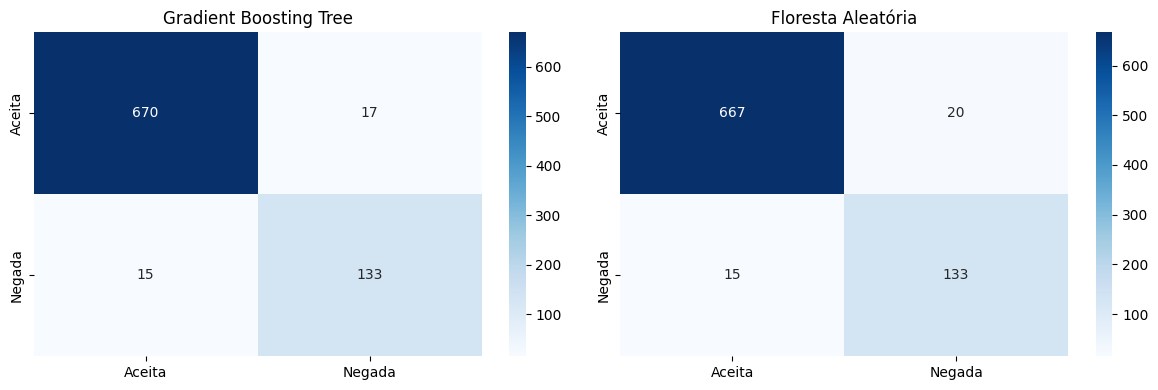

In [136]:
gb_cm = gb.get_cm()
rf_cm = rf.get_cm()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(gb_cm, annot=True, fmt="d", ax=axes[0], cmap="Blues", xticklabels=["Aceita", "Negada"], yticklabels=["Aceita", "Negada"])
axes[0].set_title("Gradient Boosting Tree")

sns.heatmap(rf_cm, annot=True, fmt="d", ax=axes[1], cmap="Blues", xticklabels=["Aceita", "Negada"], yticklabels=["Aceita", "Negada"])
axes[1].set_title("Floresta Aleatória")

plt.tight_layout()
plt.show()

#### Curva ROC

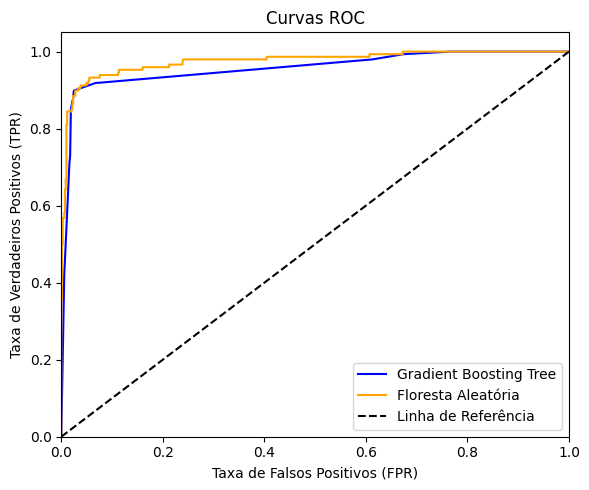

In [137]:
plt.figure(figsize=(6, 5))

def plot_roc(title, object, c):
    fpr, tpr = object.get_roc()
    plt.plot(fpr, tpr, label=title, color=c)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

plot_roc('Gradient Boosting Tree', gb, 'blue')
plot_roc('Floresta Aleatória', rf, 'orange')

plt.plot([0, 1], [0, 1], 'k--', label='Linha de Referência')

plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curvas ROC')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()            

## Técnicas não supervisionada

### SOM

Utilizou-se o SOM para identificar o agrupamento de requisições que foram aprovadas e que foram negadas

In [138]:
from sklearn import preprocessing

# Normalização dos dados
scaled_df = pd.DataFrame(preprocessing.normalize(df), columns=df.columns)

scaled_df

,unidade_requisitante,unidade_custo,grupo_material,convenio,status,almoxarifado,valor
0,0.000324,0.000405,0.000385,0.0,0.000000,0.000284,1.000000
1,0.000106,0.000106,0.000026,0.0,0.000000,0.000074,1.000000
2,0.019987,0.019987,0.016989,0.0,0.000000,0.013991,0.999358
3,0.016741,0.016741,0.016741,0.0,0.000000,0.011719,0.999511
4,0.016223,0.016223,0.016223,0.0,0.000000,0.011356,0.999541
...,...,...,...,...,...,...,...
4170,0.018975,0.018975,0.018975,0.0,0.000949,0.000000,0.999459
4171,0.000541,0.005412,0.005683,0.0,0.000271,0.000271,0.999969
4172,0.033296,0.033296,0.004994,0.0,0.001665,0.000000,0.998877
4173,0.499844,0.499844,0.499844,0.0,0.024992,0.000000,0.499844


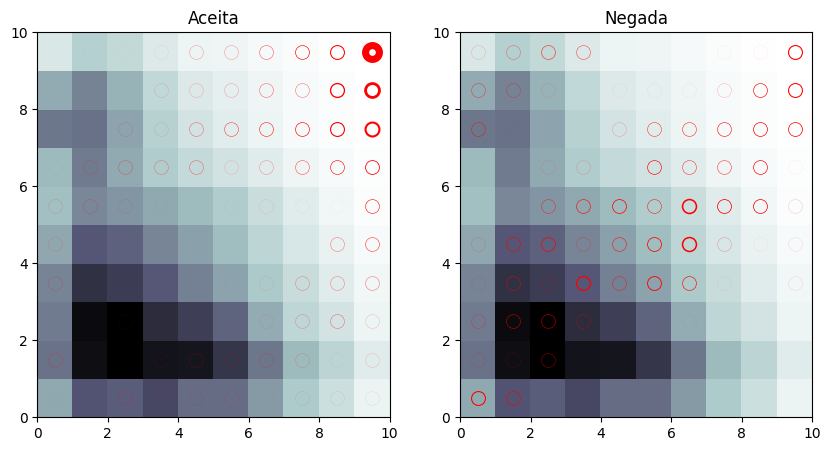

In [139]:
from minisom import MiniSom

# Extrair apenas as features
x = scaled_df.drop(columns = ['status'])
data = np.array(x, dtype=np.float64)

# Inicialize a rede SOM.
som = MiniSom(10, 10, data.shape[1], sigma=1.5, learning_rate=0.5, neighborhood_function='gaussian', random_seed=0)

# Inicialize os pesos da PCA.
som.pca_weights_init(data)

# Treine a rede SOM.
som.train(data, 10000)

# Crie a figura com dois subplots.
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

associated_data = []

# Calcular intensidade de cada neurônio vencedor
def calc_intensity(w):
    coords, counts = np.unique(w, return_counts=True, axis=0)
    coord_x = coords[:, 0]
    coord_y = coords[:, 1]
    intensity = counts / counts.sum()
    return coord_x, coord_y, intensity

for idx, label in enumerate(df['status'].drop_duplicates()):
    # Plote o mapa de distância.
    axs[idx].set_title('Aceita' if label == 0 else 'Negada')
    axs[idx].pcolor(som.distance_map().T, cmap='bone_r')
    
    # Encontre os vencedores (neurônios vencedores) para os dados com a classe label
    w = [som.winner(d) for d in data[df['status'] == label]]

    # Calcule as coordenadas e intensidade dos neurônios vencedores.
    x_points, y_points, intensity = calc_intensity(w)
    
    # Faça o gráfico dos pontos no subplot.
    for i in range(len(intensity)):
        axs[idx].plot(x_points[i] + 0.5, y_points[i] + 0.5, "o", markerfacecolor='None', markeredgecolor="red", markersize=10, markeredgewidth=20 * intensity[i])
        
# Exiba a figura.
plt.show()

In [140]:
# Recuperar todos os neuronios vencedores
w = [som.winner(d) for d in data]

# Recuperar indices neuronios vencedores na posiçao 10 x 10
winners = [idx for idx, coord in enumerate(w) if coord[0] == 9 and coord[1] == 9]

# Filtrar linhas do dataset localizadas nesses indices que foram negadas
df_winners = df.iloc[winners]
df_winners_filtered = df_winners[df_winners['status'] == 0]

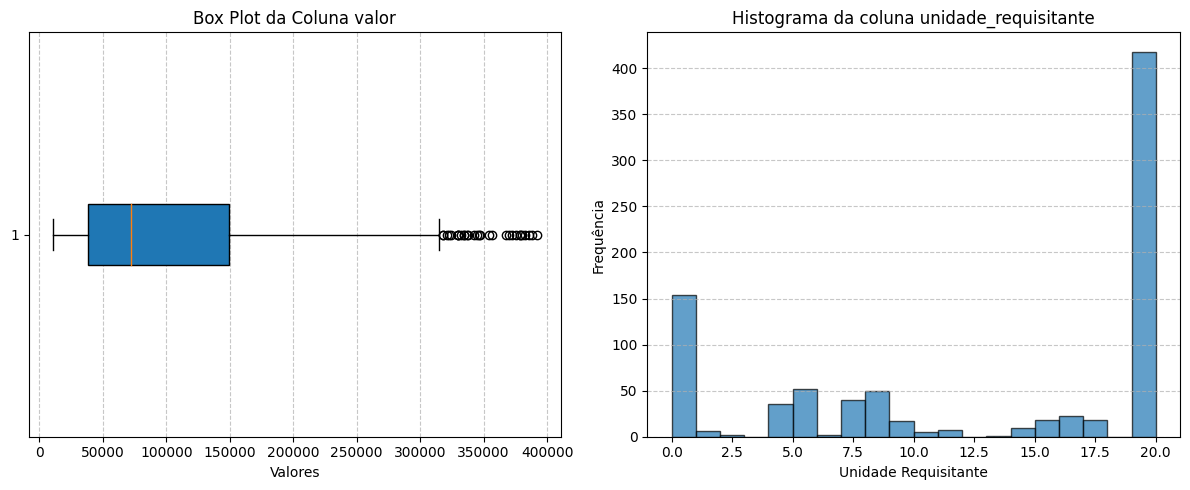

In [141]:
# Crie um subplot com 1 linha e 2 colunas
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

# Crie um gráfico de densidade de probabilidade para a coluna 'valor'
df_values_below_cutoff = df_winners_filtered[df_winners_filtered['valor'] < 400000]
plt.boxplot(df_values_below_cutoff['valor'], vert=False, patch_artist=True)
plt.xlabel('Valores')
plt.title('Box Plot da Coluna valor')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
# Crie um gráfico de densidade de probabilidade para a coluna 'unidade_requisitante'
plt.hist(df_winners_filtered['unidade_requisitante'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Unidade Requisitante')
plt.ylabel('Frequência')
plt.title('Histograma da coluna unidade_requisitante')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

# Exiba o gráfico
plt.show()


#### Erro topográfico

O erro topológico avalia a capacidade do SOM de preservar a topologia e a organização espacial dos dados de entrada no mapa de neurônios. Baixos valores de erro topológico indicam que a estrutura relativa dos dados é bem preservada no SOM.

In [142]:
som.topographic_error(data)

0.05125748502994012

#### Erro de quantização

O erro de quantização mede o quão bem os neurônios no SOM representam os dados de entrada. Valores baixos indicam uma representação de alta qualidade, onde os neurônios correspondem de forma precisa aos padrões nos dados de entrada.

In [143]:
som.quantization_error(data)

0.022557073683911504

### KMeans

In [153]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

# Aplicando o t-SNE
tsne = TSNE(n_components=2, random_state=0)
data_tsne = tsne.fit_transform(x)

# Calcular distâncias médias
inertias = []
centers = np.arange(1, 50)
for k in centers:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(data_tsne)
    inertias.append(kmeans.inertia_)

# Criação do gráfico interativo
fig = go.Figure()
fig.add_trace(go.Scatter(x=centers, y=inertias, mode='lines+markers'))
fig.update_layout(
    title='Gráfico de Inércia do K-Means',
    xaxis=dict(title='Número de Clusters (k)'),
    yaxis=dict(title='Inércia'),
)
fig.show()

Inertia: 2246914.75
Silhouette: -0.04477328641505386


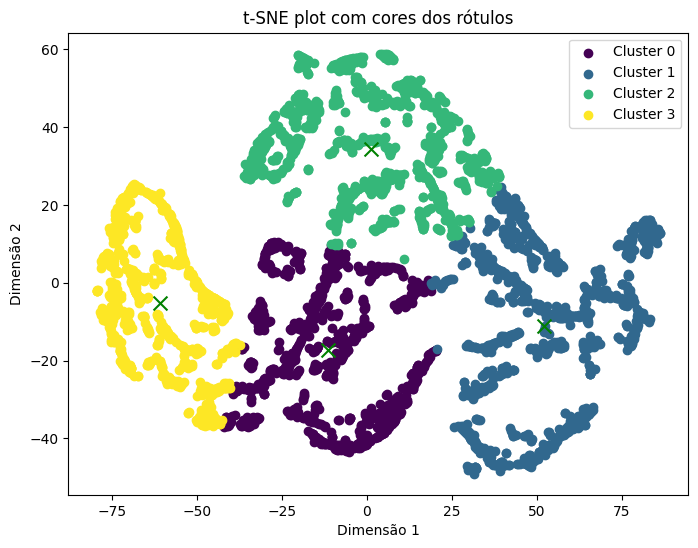

In [149]:
# Numero de centros
k = 4

# KMean no t-SNE
kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(data_tsne)
labels = kmeans.labels_
print(f"Inertia: {kmeans.inertia_}")
print(f"Silhouette: {silhouette_score(data, labels)}")

# Criando um dicionário de mapeamento de rótulos para cores
colors = plt.cm.viridis(np.linspace(0, 1, k))
color_dict = {}
for label, color in zip(range(k), colors):
    color_dict[label] = color

# Plotando os pontos com cores diferentes para cada rótulo
plt.figure(figsize=(8, 6))

for label in range(k):
    data_label = data_tsne[labels == label]
    plt.scatter(data_label[:, 0], data_label[:, 1], label=f'Cluster {label}', color=color_dict[label])

# Plotar os centros
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='green', marker='x', s=100)

plt.title('t-SNE plot com cores dos rótulos')
plt.xlabel('Dimensão 1')
plt.ylabel('Dimensão 2')
plt.legend()
plt.show()